# Password Bank – Proof of Concept in Python
This notebook presents a proof-of-concept (PoC) for a **password bank** (password manager)
that demonstrates how number theory and cryptography can be used in practice.

The goals are:

- to connect concepts from Math 3 – Discrete Mathematics (VE3020)
  (modular arithmetic, gcd, RSA, etc.) to a concrete implementation, and
- to show how such a system could be extended into a full password manager.

The notebook is structured as follows:

1. **Classical ciphers** (Caesar and Affine) as a warm-up and motivation.
2. **Number-theoretic building blocks** (gcd, modular inverses, modular exponentiation).
3. **RSA proof-of-concept**, including key generation and encryption/decryption.
4. **Hybrid encryption idea for a password bank**:
   RSA to protect a symmetric key; the symmetric key protects the actual passwords.
5. **Key derivation and security experiment**:
   using a key-derivation function (KDF) and comparing “weak” and “strong” parameters.

The focus is on the mathematical structure, not on production-ready security.

# Ceasar cipher Encrypting

In [29]:

text = "Hello from passwordbank"
shift = 3

# Enkel Caesar cipher-funksjon
def caesar_cipher(text, shift):
    result = ""
    for char in text:
        if char.isalpha():
            base = 'A' if char.isupper() else 'a'
            result += chr((ord(char) - ord(base) + shift) % 26 + ord(base))
        else:
            result += char
    return result

encrypted = caesar_cipher(text, shift)
print(f"Kryptert tekst: {encrypted}")


Kryptert tekst: Khoor iurp sdvvzrugedqn


# Decrypt ceasar cipher


In [30]:
def caesar_decrypt(ciphertext, shift):
    decrypted = ""
    for char in ciphertext:
        if char.isalpha():
            base = 'A' if char.isupper() else 'a'
            decrypted += chr((ord(char) - ord(base) - shift) % 26 + ord(base))
        else:
            decrypted += char
    return decrypted



decrypted_text = caesar_decrypt(encrypted, shift)
print(f"Dekryptert tekst: {decrypted_text}")


Dekryptert tekst: Hello from passwordbank


## Caesar cipher and letter frequencies

The Caesar cipher can be written as
C = (P + K) mod 26
where $P$ is the plaintext letter, $C$ is the ciphertext letter, and $K$ is
the shift. This is an example of modular addition in $\mathbb{Z}_{26}$.

A classical way to break such ciphers is to look at **letter frequencies**.
Because Caesar is just a shift of the alphabet, the frequency distribution of
the ciphertext is almost the same as in the plaintext, just shifted.

The following helper function visualises letter frequencies for a given text.


In [31]:
import string
import collections
import matplotlib.pyplot as plt

def letter_frequencies(text: str):
    text = text.upper()
    counts = collections.Counter(ch for ch in text if ch in string.ascii_uppercase)
    freqs = [counts.get(chr(ord('A') + i), 0) for i in range(26)]
    return freqs

def plot_letter_frequencies(text: str, title: str):
    freqs = letter_frequencies(text)
    letters = list(string.ascii_uppercase)

    plt.figure(figsize=(10, 4))
    plt.bar(letters, freqs)
    plt.xlabel("Letter")
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()


Plaintext:
 THIS IS A SIMPLE EXAMPLE OF A CAESAR CIPHER USED IN A PASSWORD BANK DEMO

Ciphertext (shift = 3):
 WKLV LV D VLPSOH HADPSOH RI D FDHVDU FLSKHU XVHG LQ D SDVVZRUG EDQN GHPR


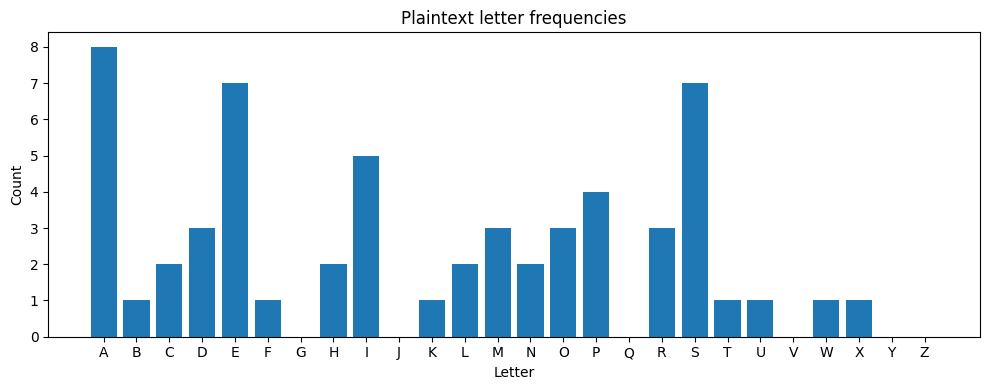

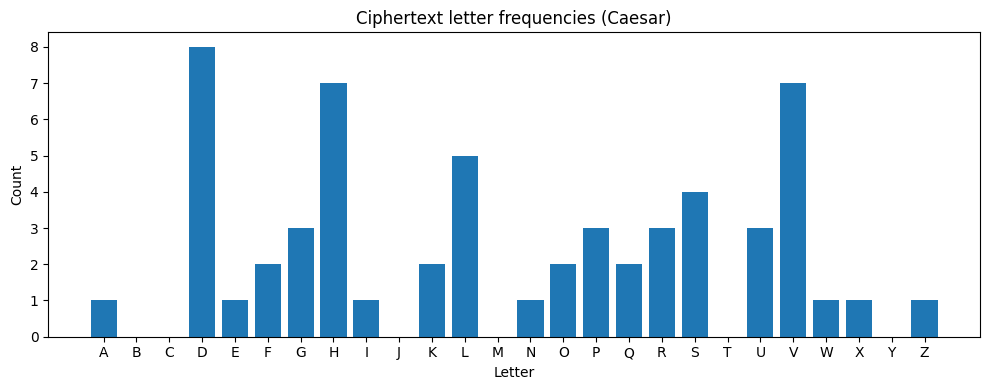

In [32]:
sample_plain = "THIS IS A SIMPLE EXAMPLE OF A CAESAR CIPHER USED IN A PASSWORD BANK DEMO"
sample_cipher = caesar_cipher(sample_plain, shift=3)

print("Plaintext:\n", sample_plain)
print("\nCiphertext (shift = 3):\n", sample_cipher)

plot_letter_frequencies(sample_plain, "Plaintext letter frequencies")
plot_letter_frequencies(sample_cipher, "Ciphertext letter frequencies (Caesar)")


# Affine cipher
Source for this code is https://www.geeksforgeeks.org/dsa/implementation-affine-cipher/ and should be modified

In [33]:
from math import gcd

def egcd(a: int, b: int):
    """
    Extended Euclidean Algorithm.
    Returns (g, x, y) such that ax + by = g = gcd(a, b).
    """
    if b == 0:
        return a, 1, 0
    else:
        g, x1, y1 = egcd(b, a % b)
        x = y1
        y = x1 - (a // b) * y1
        return g, x, y


def modinv(a: int, m: int) -> int:
    """
    Modular inverse of a modulo m.
    Returns x such that a*x ≡ 1 (mod m), if gcd(a, m) = 1.
    Raises ValueError if inverse does not exist.
    """
    g, x, _ = egcd(a, m)
    if g != 1:
        raise ValueError(f"No modular inverse for a={a} modulo m={m}")
    return x % m


In [34]:
# Find coprime numbers for 26

import math

def find_coprime_numbers(m):
    coprimes = [a for a in range(1, m) if math.gcd(a, m) == 1]
    return coprimes

print("Numbers coprime with 26:")
print(find_coprime_numbers(26))


Numbers coprime with 26:
[1, 3, 5, 7, 9, 11, 15, 17, 19, 21, 23, 25]


In [35]:
# Affine Cipher Implementation (non-interactive demo)

def affine_encrypt(text, key):
    """
    Encrypt text using the Affine cipher:
    C ≡ aP + b (mod 26)
    """
    a, b = key
    result = ""
    for char in text:
        if char.isalpha():
            base = ord('A') if char.isupper() else ord('a')
            p = ord(char) - base
            c = (a * p + b) % 26
            result += chr(c + base)
        else:
            result += char
    return result


def affine_decrypt(cipher, key):
    """
    Decrypt Affine cipher using:
    P ≡ a^{-1}(C - b) (mod 26)
    """
    a, b = key
    a_inv = modinv(a, 26)  # bruker den kanoniske modinv-definisjonen
    result = ""
    for char in cipher:
        if char.isalpha():
            base = ord('A') if char.isupper() else ord('a')
            c = ord(char) - base
            p = (a_inv * (c - b)) % 26
            result += chr(p + base)
        else:
            result += char
    return result


# Demo values
text = "HELLOAFFINE"
a, b = 5, 8  # gcd(5, 26) = 1, så 5 har invers mod 26

encrypted_affine = affine_encrypt(text, (a, b))
decrypted_affine = affine_decrypt(encrypted_affine, (a, b))

print("Plaintext: ", text)
print("Encrypted:", encrypted_affine)
print("Decrypted:", decrypted_affine)


Plaintext:  HELLOAFFINE
Encrypted: RCLLAIHHWVC
Decrypted: HELLOAFFINE


## Affine cipher as a linear map over $\mathbb{Z}_{26}$

The Affine cipher generalises Caesar by using
\[
C \equiv aP + b \pmod{26},
\]
with two keys $a$ and $b$. The coefficient $a$ must be chosen so that
$\gcd(a, 26) = 1$, otherwise no modular inverse exists and decryption would
be impossible.

In algebraic terms, the Affine cipher is a linear map on the ring
$\mathbb{Z}_{26}$, and decryption uses the modular inverse $a^{-1}$ such that
\[
a \cdot a^{-1} \equiv 1 \pmod{26}.
\]

This is a first appearance of the number-theoretic tools that will also be used
later for RSA.


## Number-theoretic building blocks

Before implementing RSA, we need two core tools from number theory
(see~\cite{manninen2025ve3020}):

1. The **greatest common divisor** $\gcd(a,b)$, and the notion of
   coprimality ($\gcd(a,b) = 1$).
2. The **extended Euclidean algorithm**, which produces integers $u$ and $v$
   such that
   \[
   ua + vb = \gcd(a,b),
   \]
   and in particular the modular inverse $a^{-1} \bmod m$ when $\gcd(a,m)=1$.

The next cell tests the modular inverse implementation used later in RSA.


## RSA proof-of-concept

This section implements the RSA cryptosystem following the mathematical
description in the report:

- Two primes $p$ and $q$ are chosen and
  \[
  n = pq, \quad \varphi(n) = (p-1)(q-1).
  \]
- A public exponent $e$ is chosen such that
  \[
  1 < e < \varphi(n), \quad \gcd(e, \varphi(n)) = 1.
  \]
- The private exponent $d$ is computed as the modular inverse
  \[
  ed \equiv 1 \pmod{\varphi(n)}.
  \]

Encryption and decryption are then given by
\[
C \equiv P^e \pmod{n}, \qquad P \equiv C^d \pmod{n},
\]
which is exactly what is implemented in the following cells.


In [36]:
# RSA proof-of-concept for the report / appendix.
# Educational code, not suitable for production use
# (no padding, no side-channel protections, etc.).

import secrets
from math import gcd

In [37]:
test_values = [(7, 26), (17, 3120), (35, 64)]

for a, m in test_values:
    g = gcd(a, m)
    print(f"gcd({a}, {m}) = {g}")
    if g == 1:
        inv = modinv(a, m)
        print(f"  Inverse of {a} modulo {m} is {inv}")
        print(f"  Check: ({a} * {inv}) % {m} = {(a * inv) % m}")
    else:
        print(f"  No modular inverse for {a} modulo {m} since gcd != 1")
    print()


gcd(7, 26) = 1
  Inverse of 7 modulo 26 is 15
  Check: (7 * 15) % 26 = 1

gcd(17, 3120) = 1
  Inverse of 17 modulo 3120 is 2753
  Check: (17 * 2753) % 3120 = 1

gcd(35, 64) = 1
  Inverse of 35 modulo 64 is 11
  Check: (35 * 11) % 64 = 1



In [38]:
def is_probable_prime(n: int, k: int = 10) -> bool:
    """
    Miller–Rabin probabilistic primality test.
    Returns True if n is probably prime, False if composite.
    k is the number of rounds.
    """
    if n < 2:
        return False
    # Handle small primes explicitly
    small_primes = [2, 3, 5, 7, 11, 13, 17, 19, 23]
    if n in small_primes:
        return True
    if any(n % p == 0 for p in small_primes):
        return False

    # Write n-1 as 2^r * d with d odd
    r = 0
    d = n - 1
    while d % 2 == 0:
        r += 1
        d //= 2

    for _ in range(k):
        a = secrets.randbelow(n - 3) + 2  # random in [2, n-2]
        x = pow(a, d, n)
        if x == 1 or x == n - 1:
            continue
        for _ in range(r - 1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
    return True


def generate_prime(bits: int) -> int:
    """
    Generate a random prime with the given bit length.
    Uses Miller–Rabin to test primality.
    """
    if bits < 2:
        raise ValueError("Bit length must be at least 2")

    while True:
        # Generate random odd candidate
        candidate = secrets.randbits(bits) | 1
        # Ensure top bit is set so we truly get 'bits'-bit numbers
        candidate |= (1 << (bits - 1))
        if is_probable_prime(candidate):
            return candidate


In [39]:
def generate_rsa_keypair(bits: int = 512):
    """
    Generate an RSA key pair of approximately 'bits' bits.
    - p and q are primes of ~bits/2 bits.
    - n = p*q
    - phi = (p-1)(q-1)
    - e chosen coprime with phi (default 65537 if possible)
    - d = e^{-1} mod phi
    """
    # Choose two distinct primes
    half_bits = bits // 2
    p = generate_prime(half_bits)
    q = generate_prime(half_bits)
    while q == p:
        q = generate_prime(half_bits)

    n = p * q
    phi = (p - 1) * (q - 1)

    # Standard public exponent
    e = 65537
    if gcd(e, phi) != 1:
        # Fallback: find another e
        e = 3
        while gcd(e, phi) != 1:
            e += 2

    d = modinv(e, phi)

    public_key = (n, e)
    private_key = (n, d)

    return public_key, private_key, (p, q, phi)


# Example: generate a 512-bit key pair
public_key, private_key, internal_values = generate_rsa_keypair(bits=512)
n, e = public_key
_, d = private_key

print("Public key (n, e):")
print("n =", n)
print("e =", e)
print()
print("Private exponent d:")
print("d =", d)


Public key (n, e):
n = 5331186215997845016151063566305629224044778313826483066270390288800820840211604609686398690582750271502743122449352575689705231275213831160914120969732509
e = 65537

Private exponent d:
d = 2320969911879556799988131066021212643551667223859761887892744186033309736681772680986288165512917268231745053551708878036773834883010518852656391629982513


In [40]:
def encrypt_int(m: int, public_key: tuple[int, int]) -> int:
    """
    Encrypt an integer m with public key (n, e).
    Requires 0 ≤ m < n.
    """
    n, e = public_key
    if not (0 <= m < n):
        raise ValueError("Message integer out of range (must be < n)")
    return pow(m, e, n)


def decrypt_int(c: int, private_key: tuple[int, int]) -> int:
    """
    Decrypt an integer c with private key (n, d).
    """
    n, d = private_key
    return pow(c, d, n)


def text_to_int(text: str) -> int:
    """
    Encode a UTF-8 string as a big-endian integer.
    """
    data = text.encode("utf-8")
    return int.from_bytes(data, byteorder="big")


def int_to_text(m: int) -> str:
    """
    Decode a big-endian integer back to a UTF-8 string.
    """
    if m == 0:
        return ""
    # Compute the minimum number of bytes needed
    length = (m.bit_length() + 7) // 8
    data = m.to_bytes(length, byteorder="big")
    return data.decode("utf-8")


In [41]:
message = "Hello RSA from the password bank"

print("Original message:")
print(message)

# Encode message as integer
m = text_to_int(message)
print("\nMessage as integer m:")
print(m)

# Encrypt
c = encrypt_int(m, public_key)
print("\nCiphertext integer c:")
print(c)

# Decrypt
m_dec = decrypt_int(c, private_key)
print("\nDecrypted integer m_dec:")
print(m_dec)

# Convert back to text
decoded_message = int_to_text(m_dec)
print("\nDecoded message:")
print(decoded_message)

print("\nDecryption correct?", decoded_message == message)


Original message:
Hello RSA from the password bank

Message as integer m:
32745724963520450916509782688602831250971793034266645229058059736080653053547

Ciphertext integer c:
980795899052998046380944316483158367291382768061875206164177591522185995455452461257714324789560506751755024692508299938008539328635596190844024305771160

Decrypted integer m_dec:
32745724963520450916509782688602831250971793034266645229058059736080653053547

Decoded message:
Hello RSA from the password bank

Decryption correct? True


In [42]:
# Toy RSA example with small primes (not secure, just for illustration)

p = 61
q = 53
n = p * q
phi = (p - 1) * (q - 1)

e = 17  # must satisfy gcd(e, phi) = 1
print("gcd(e, phi) =", gcd(e, phi))

d = modinv(e, phi)

print("Toy RSA parameters:")
print("p =", p)
print("q =", q)
print("n =", n)
print("phi =", phi)
print("e =", e)
print("d =", d)

P = 65  # example plaintext integer (0 ≤ P < n)
C = pow(P, e, n)
P_dec = pow(C, d, n)

print("\nPlaintext P:", P)
print("Ciphertext C:", C)
print("Decrypted P_dec:", P_dec)
print("Decryption correct?", P == P_dec)


gcd(e, phi) = 1
Toy RSA parameters:
p = 61
q = 53
n = 3233
phi = 3120
e = 17
d = 2753

Plaintext P: 65
Ciphertext C: 2790
Decrypted P_dec: 65
Decryption correct? True


## From RSA to a password bank (hybrid encryption)

In a real password bank, each stored password should be encrypted with a
**symmetric key** $K$ (for example used with AES-GCM). RSA is then used only to
protect this key $K$.

The high-level design is:

1. Generate a random symmetric key $K$.
2. Encrypt all password entries with $K$.
3. Encrypt $K$ with RSA and store the RSA-encrypted key.
4. To unlock the password bank, use the RSA private key to recover $K$, then
   decrypt all password entries.

In this notebook, a simple toy symmetric cipher (XOR on bytes) is used instead
of AES. The goal is to illustrate the structure; the same structure can be used
with a real cipher such as AES-GCM.

For simplicity, the "database" is simulated with Python dictionaries, but the
same logic could be implemented with an SQLite database.


In [43]:
import secrets

def toy_symmetric_encrypt(plaintext: bytes, key: bytes) -> bytes:
    return bytes([p ^ key[i % len(key)] for i, p in enumerate(plaintext)])

def toy_symmetric_decrypt(ciphertext: bytes, key: bytes) -> bytes:
    return toy_symmetric_encrypt(ciphertext, key)  # XOR is its own inverse

# Use existing RSA key generation
public_key_hybrid, private_key_hybrid, _ = generate_rsa_keypair(bits=512)
n_h, e_h = public_key_hybrid
_, d_h = private_key_hybrid

# 1) Generate symmetric key K
K = secrets.token_bytes(16)  # 128-bit key
print("Symmetric key K (hex):", K.hex())

# 2) RSA-encrypt K
K_int = int.from_bytes(K, byteorder="big")
C_K = encrypt_int(K_int, public_key_hybrid)
print("RSA-encrypted key C_K:", C_K)

# 3) Simulated password "database"
password_db_plain = {
    "example.com": "MySecurePassword123!",
    "mail.example.com": "AnotherPass456?",
}

password_db_encrypted = {}
for site, pw in password_db_plain.items():
    pw_bytes = pw.encode("utf-8")
    pw_enc = toy_symmetric_encrypt(pw_bytes, K)
    password_db_encrypted[site] = pw_enc

print("\nEncrypted password entries (toy symmetric cipher):")
for site, pw_enc in password_db_encrypted.items():
    print(f"{site}: {pw_enc.hex()}")


Symmetric key K (hex): 32bd50f68edf89679860fd191e9ef392
RSA-encrypted key C_K: 1297621927876721261952035402264553802033515513558689408240800921218912329997156296734792243072256104144195311341024713279206714071550023905332839774861262

Encrypted password entries (toy symmetric cipher):
example.com: 7fc40393edaafb02c8018e6a69f181f6038f63d7
mail.example.com: 73d33f82e6bafb37f9138e2d2ba8cc


In [44]:
# 4) Unlock: recover K with RSA, then decrypt all passwords

K_int_recovered = decrypt_int(C_K, private_key_hybrid)
K_recovered = K_int_recovered.to_bytes(len(K), byteorder="big")

print("Recovered symmetric key K (hex):", K_recovered.hex())
print("Keys equal?", K_recovered == K)

recovered_passwords = {}
for site, pw_enc in password_db_encrypted.items():
    pw_dec_bytes = toy_symmetric_decrypt(pw_enc, K_recovered)
    pw_dec = pw_dec_bytes.decode("utf-8")
    recovered_passwords[site] = pw_dec

print("\nDecrypted password entries:")
for site, pw in recovered_passwords.items():
    print(f"{site}: {pw}")

print("\nDecryption correct?", recovered_passwords == password_db_plain)


Recovered symmetric key K (hex): 32bd50f68edf89679860fd191e9ef392
Keys equal? True

Decrypted password entries:
example.com: MySecurePassword123!
mail.example.com: AnotherPass456?

Decryption correct? True


## Simulating storage with SQLite

Even though this notebook runs inside Jupyter, it is still possible to use a
local SQLite database. The following cell shows a minimal example that stores
encrypted password entries in an in-memory SQLite database.


In [45]:
import sqlite3

# In-memory database for demonstration; replace ":memory:" with "password_bank.db" for a file-backed DB.
conn = sqlite3.connect(":memory:")

cur = conn.cursor()

cur.execute("""
CREATE TABLE passwords (
    site TEXT PRIMARY KEY,
    username TEXT,
    password_enc BLOB
)
""")

# Insert encrypted passwords from the toy hybrid example
for site, pw_enc in password_db_encrypted.items():
    cur.execute(
        "INSERT INTO passwords (site, username, password_enc) VALUES (?, ?, ?)",
        (site, "user@example", pw_enc)
    )

conn.commit()

# Read back and decrypt
cur.execute("SELECT site, username, password_enc FROM passwords")
rows = cur.fetchall()

print("Rows in SQLite table:")
for site, username, pw_enc in rows:
    pw_dec = toy_symmetric_decrypt(pw_enc, K_recovered).decode("utf-8")
    print(f"{site:20} {username:15} {pw_dec}")


Rows in SQLite table:
example.com          user@example    MySecurePassword123!
mail.example.com     user@example    AnotherPass456?


## Key derivation and security experiment

In a complete system, a user-provided master password would be turned into a
cryptographic key using a **key-derivation function** (KDF), for example PBKDF2
or Argon2. The idea is to make each password guess *expensive*.

Here we use Python's built-in PBKDF2 implementation and compare how the runtime
depends on the number of iterations.


Iterations:   1000  Time: 0.0006 s
Iterations:  10000  Time: 0.0081 s
Iterations:  50000  Time: 0.0227 s
Iterations: 100000  Time: 0.0522 s


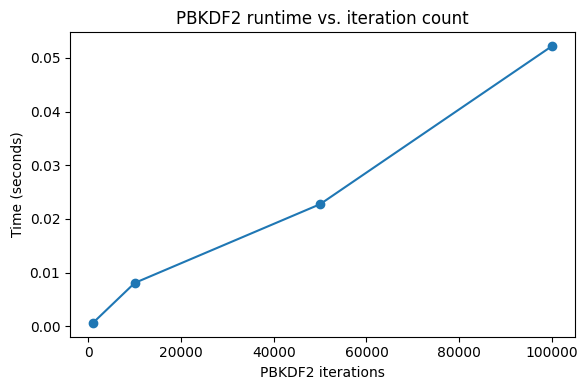

In [46]:
import hashlib
import time

def derive_key_pbkdf2(password: str, salt: bytes, iterations: int, dk_len: int = 32) -> bytes:
    return hashlib.pbkdf2_hmac(
        'sha256',
        password.encode("utf-8"),
        salt,
        iterations,
        dk_len
    )

salt = secrets.token_bytes(16)
password = "correct horse battery staple"  # example master password

iteration_values = [1_000, 10_000, 50_000, 100_000]
times = []

for iters in iteration_values:
    t0 = time.perf_counter()
    _ = derive_key_pbkdf2(password, salt, iterations=iters)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    times.append(elapsed)
    print(f"Iterations: {iters:6}  Time: {elapsed:.4f} s")

plt.figure(figsize=(6, 4))
plt.plot(iteration_values, times, marker="o")
plt.xlabel("PBKDF2 iterations")
plt.ylabel("Time (seconds)")
plt.title("PBKDF2 runtime vs. iteration count")
plt.tight_layout()
plt.show()
